In [21]:
from scipy.io import wavfile
import numpy as np
import sounddevice as sd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import sys

# KYW inst
#fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final Project/Music-Technology-Final-Project/Sound Examples/KYW Inst.wav')
#ATF Drums
fs, data = wavfile.read('/Users/kevinbrennan/Desktop/Final Project/Music-Technology-Final-Project/Sound Examples/Around the fur drums.wav')


# Original interrupted noise and sweep
fs_2, noise_sweep = wavfile.read('IR_measurement_2022_stimulus_final.wav')


# Recorder Responses in room
fs_3, response = wavfile.read('Recorded Responses/SittingRoom.WAV')



# Get the bit depth of the audio data (assumes audio_data is a NumPy array)
bit_depth = data.dtype.itemsize * 8

# Calculate the scaling factor for normalization
scaling_factor = 2 ** (bit_depth - 1)  # For signed audio

# Convert audio data to floating-point values and normalize
data = data.astype(np.float32) / scaling_factor

# Verify that the data is now in the range -1 to 1
print(f"Min Value: {np.min(data)}")
print(f"Max Value: {np.max(data)}")

#Convert audio to proper form
bit_depth = noise_sweep.dtype.itemsize * 8
scaling_factor = 2 ** (bit_depth - 1)
noise_sweep = noise_sweep.astype(np.float32) / scaling_factor

bit_depth = response.dtype.itemsize * 8
scaling_factor = 2 ** (bit_depth - 1)
response = response.astype(np.float32) / scaling_factor

Min Value: -1.0
Max Value: 0.999969482421875


/var/folders/wl/6gyc0yz53snb8mbsbvf6rnh80000gn/T/ipykernel_14235/549038677.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_3, response = wavfile.read('Recorded Responses/SittingRoom.WAV')


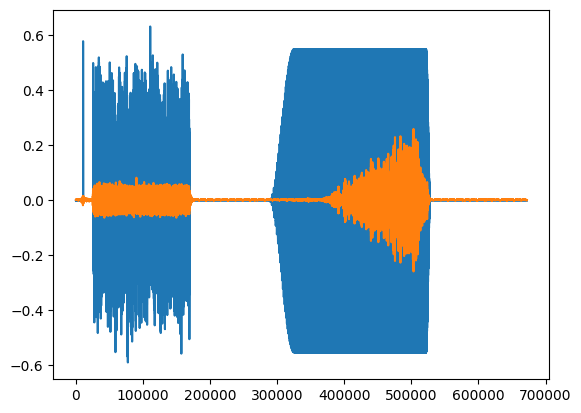

In [2]:
rec_clickpos = (fs*15)-4000
plt.plot(noise_sweep)
plt.plot(response[rec_clickpos:rec_clickpos + len(noise_sweep),0])

In [3]:
#Clap
clap = response[130000:160000,:]

#Convolve left and right tails with left and right signal
data_conv_clap_L = np.convolve(data[:,0], clap[:,0])
data_conv_clap_L = ((data_conv_clap_L - np.min(data_conv_clap_L)) / (np.max(data_conv_clap_L) - np.min(data_conv_clap_L))) * 2 - 1
data_conv_clap_R = np.convolve(data[:,1], clap[:,1])
data_conv_clap_R = ((data_conv_clap_R - np.min(data_conv_clap_R)) / (np.max(data_conv_clap_R) - np.min(data_conv_clap_R))) * 2 - 1

#Create output data
data_conv_clap = np.vstack((data_conv_clap_L, data_conv_clap_R))
data_conv_clap = data_conv_clap.T


In [4]:
sd.play(data_conv_clap, fs)

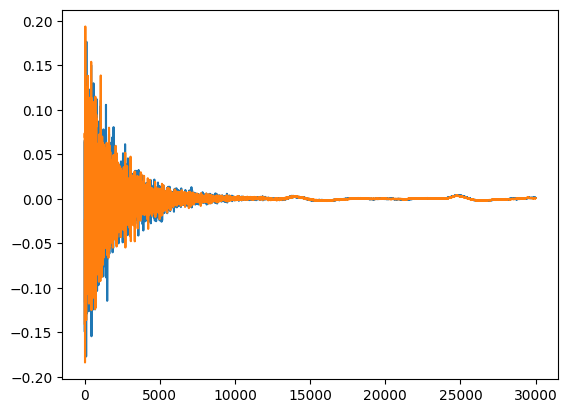

In [6]:
plt.plot(clap)

In [22]:
# Noise

#Cut recording down to just noise
rec_noise = response[rec_clickpos:rec_clickpos+200000]

clickpos = 10752
endpos = 169653
stimlen = endpos - clickpos

noiseEnd = clickpos + stimlen

#Remove noise and retain tail only
rec_noise_tail = rec_noise[noiseEnd:]
tail = rec_noise_tail[0:20000]

#Convolve left and right tails with left and right signal
data_conv_tail_L = np.convolve(data[:,0], tail[:,0])
data_conv_tail_R = np.convolve(data[:,1], tail[:,1])

#Create output data
data_conv_tail = np.vstack((data_conv_tail_L, data_conv_tail_R))
data_conv_tail = data_conv_tail.T

In [23]:
sd.play(data_conv_tail, fs)

In [81]:
sd.play(data,fs)

In [7]:
# Sweep
sweep = noise_sweep[288000:528000]
stim_lenFromClick = 288000 - clickpos

#Computing equalised inverse sweep
t_inv = np.linspace(0, (len(sweep) - 1)/fs, len(sweep))
t_inv = t_inv.T
L = (len(sweep)/fs) / np.log(20/24000)
invsweep = np.flipud(sweep) * np.exp(-t_inv/L)

# Normalising
invsweep = ((invsweep - np.min(invsweep)) / (np.max(invsweep) - np.min(invsweep))) * 2 - 1

rec_sweepstart = rec_clickpos + stim_lenFromClick

rec_sweep = response[rec_sweepstart : rec_sweepstart + 250000]

# Convolving left and right recorded sweeps with inverse sweep to obtain IR
sweepconvL = np.convolve(rec_sweep[:,0], invsweep)
sweepconvL = ((sweepconvL - np.min(sweepconvL)) / (np.max(sweepconvL) - np.min(sweepconvL))) * 2 - 1
IR_L = sweepconvL[250000:270000]
sweepconvR = np.convolve(rec_sweep[:,1], invsweep)
sweepconvR = ((sweepconvR - np.min(sweepconvR)) / (np.max(sweepconvR) - np.min(sweepconvR))) * 2 - 1
IR_R= sweepconvR[250000:270000]


#Convolve IRs with data
data_conv_IR_L = np.convolve(data[:,0], IR_L)
data_conv_IR_L = ((data_conv_IR_L - np.min(data_conv_IR_L)) / (np.max(data_conv_IR_L) - np.min(data_conv_IR_L))) * 2 - 1
data_conv_IR_R = np.convolve(data[:,1], IR_R)
data_conv_IR_R = ((data_conv_IR_R - np.min(data_conv_IR_R)) / (np.max(data_conv_IR_R) - np.min(data_conv_IR_R))) * 2 - 1

#Create output data
data_conv_IR = np.vstack((data_conv_IR_L, data_conv_IR_R))
data_conv_IR = data_conv_IR.T


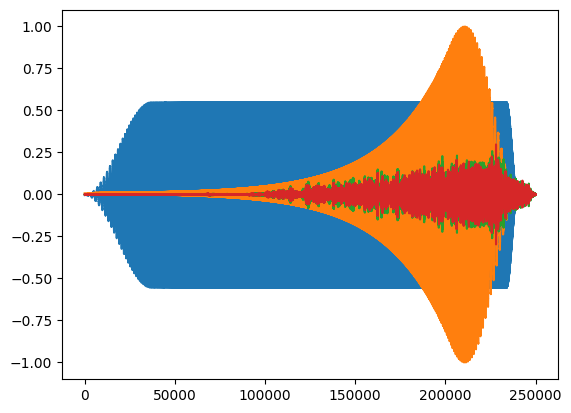

In [73]:
plt.plot(sweep)
plt.plot(invsweep)
plt.plot(rec_sweep)

In [8]:
sd.play(data_conv_IR,fs)